In [3]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM

from Optimizers import SVD_LM

## Utils

In [4]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [5]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(vmapped_rhs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [6]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [7]:
def run_exp(m, obs_pts,run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(2*(jnp.sin(jnp.cos(2*x) + jnp.cos(2*y))))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [obs_pts]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = SVD_LM(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    ########### Errors ################
    
    # In sample

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))



    # In distribution

    M = 50
    kernel_GP = get_gaussianRBF(0.5)
    # Sample M training functions from GP(0,K)
    w_train_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_train_functions = tuple([jax.vmap(w) for w in w_train_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_train_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_train_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_train_functions
    ]

    i_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))


    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.75)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    o_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    o_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_dis_1_5, i_dis_2, o_dis_1_5, o_dis_2, i_smpl_1_5, i_smpl_2

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [8]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                }
}

In [9]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 1
OBS_PTS_LIST = [2,4,8]

for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        o_dis_1_5 = []
        o_dis_2 = []
        i_smpl_1_5 = []
        i_smpl_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
            o_dis_1_5.append(res[2])
            o_dis_2.append(res[3])
            i_smpl_1_5.append(res[4])
            i_smpl_2.append(res[5])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_2)    
    # Save after 
    jnp.save('errors/err', err)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.675e+03, Jres = 570.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.168e+03, Jres = 1.496e+04, alpha = 20.0, improvement_ratio = 0.4149
Iteration 2, loss = 205.1, Jres = 4.147e+04, alpha = 16.67, improvement_ratio = 0.9778
Iteration 3, loss = 112.3, Jres = 4.541e+03, alpha = 13.89, improvement_ratio = 1.017
Iteration 4, loss = 78.55, Jres = 993.9, alpha = 11.57, improvement_ratio = 1.005
Iteration 5, loss = 60.39, Jres = 562.3, alpha = 9.645, improvement_ratio = 0.9971
Iteration 50, loss = 0.09842, Jres = 7.098, alpha = 0.002637, improvement_ratio = 0.9872
Iteration 100, loss = 0.002449, Jres = 5.913, alpha = 0.0001426, improvement_ratio = 0.6718
Iteration 150, loss = 0.0003773, Jres = 2.678, alpha = 4.777e-05, improvement_ratio = 0.6736
Iteration 200, loss = 0.0001221, Jres = 1.071, alpha = 1.333e-05, improvement_ratio = 0.7752
Iteration 250, loss = 7.951e-05, Jres = 0.4732, alpha = 6.429e-06, improvement_ratio = 0.8026
Iteration 300, loss = 6.597e-

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.155e+03, Jres = 556.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 488.6, Jres = 7.709e+03, alpha = 10.0, improvement_ratio = 0.7314
Iteration 2, loss = 90.92, Jres = 1.551e+04, alpha = 8.333, improvement_ratio = 0.9659
Iteration 3, loss = 54.39, Jres = 1.692e+03, alpha = 6.944, improvement_ratio = 0.9968
Iteration 4, loss = 38.37, Jres = 326.0, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 28.57, Jres = 186.1, alpha = 4.823, improvement_ratio = 1.002
Iteration 50, loss = 0.04694, Jres = 21.93, alpha = 0.001319, improvement_ratio = 0.8163
Iteration 100, loss = 0.002502, Jres = 4.381, alpha = 8.559e-05, improvement_ratio = 0.6761
Iteration 150, loss = 0.0006614, Jres = 3.778, alpha = 3.439e-05, improvement_ratio = 0.7507
Iteration 200, loss = 0.000233, Jres = 2.076, alpha = 1.659e-05, improvement_ratio = 0.799
Iteration 250, loss = 0.0001285, Jres = 1.198, alpha = 6.666e-06, improvement_ratio = 0.6645
Iteration 300, loss = 9.884e-05, Jre

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 838.5, Jres = 835.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 771.0, Jres = 4.883e+03, alpha = 3.0, improvement_ratio = 0.1004
Iteration 2, loss = 61.5, Jres = 1.732e+04, alpha = 2.5, improvement_ratio = 0.9671
Iteration 3, loss = 26.68, Jres = 1.902e+03, alpha = 2.083, improvement_ratio = 0.9919
Iteration 4, loss = 18.22, Jres = 199.3, alpha = 1.736, improvement_ratio = 1.013
Iteration 5, loss = 13.73, Jres = 74.59, alpha = 1.447, improvement_ratio = 1.012
Iteration 50, loss = 0.02259, Jres = 31.37, alpha = 0.0006836, improvement_ratio = 0.7731
Iteration 100, loss = 0.001604, Jres = 9.382, alpha = 5.324e-05, improvement_ratio = 0.6692
Iteration 150, loss = 0.0004663, Jres = 4.67, alpha = 2.568e-05, improvement_ratio = 0.7947
Iteration 200, loss = 0.0002079, Jres = 4.882, alpha = 1.032e-05, improvement_ratio = 0.7983
Iteration 250, loss = 0.0001253, Jres = 4.011, alpha = 4.147e-06, improvement_ratio = 0.7844
Iteration 300, loss = 9.904e-05, Jres = 2.

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.415e+03, Jres = 1.74e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 615.3, Jres = 5.959e+03, alpha = 2.5, improvement_ratio = 0.6871
Iteration 2, loss = 69.36, Jres = 1.157e+04, alpha = 2.083, improvement_ratio = 0.9727
Iteration 3, loss = 36.36, Jres = 1.175e+03, alpha = 1.736, improvement_ratio = 0.9978
Iteration 4, loss = 25.13, Jres = 169.0, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 18.85, Jres = 77.89, alpha = 1.206, improvement_ratio = 1.011
Iteration 50, loss = 0.02542, Jres = 25.42, alpha = 0.0003297, improvement_ratio = 0.8061
Iteration 100, loss = 0.001447, Jres = 7.691, alpha = 3.697e-05, improvement_ratio = 0.6678
Iteration 150, loss = 0.0005485, Jres = 8.26, alpha = 1.238e-05, improvement_ratio = 0.7741
Iteration 200, loss = 0.0002748, Jres = 7.471, alpha = 4.976e-06, improvement_ratio = 0.7307
Iteration 250, loss = 0.0001937, Jres = 3.292, alpha = 2e-06, improvement_ratio = 0.8032
Iteration 300, loss = 0.000168, Jres

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.673e+03, Jres = 579.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.041e+03, Jres = 1.436e+04, alpha = 20.0, improvement_ratio = 0.5271
Iteration 2, loss = 215.5, Jres = 3.517e+04, alpha = 16.67, improvement_ratio = 0.9785
Iteration 3, loss = 120.4, Jres = 3.926e+03, alpha = 13.89, improvement_ratio = 1.023
Iteration 4, loss = 83.2, Jres = 931.5, alpha = 11.57, improvement_ratio = 1.01
Iteration 5, loss = 63.13, Jres = 530.8, alpha = 9.645, improvement_ratio = 0.9997
Iteration 50, loss = 0.1237, Jres = 13.56, alpha = 0.002637, improvement_ratio = 0.9754
Iteration 100, loss = 0.003842, Jres = 11.71, alpha = 0.0001426, improvement_ratio = 0.7876
Iteration 150, loss = 0.0006328, Jres = 4.278, alpha = 3.981e-05, improvement_ratio = 0.8084
Iteration 200, loss = 0.0002407, Jres = 2.713, alpha = 1.6e-05, improvement_ratio = 0.8009
Iteration 250, loss = 0.0001257, Jres = 1.636, alpha = 7.715e-06, improvement_ratio = 0.802
Iteration 300, loss = 9.56e-05, Jres

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.144e+03, Jres = 564.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 503.9, Jres = 7.872e+03, alpha = 10.0, improvement_ratio = 0.6982
Iteration 2, loss = 87.35, Jres = 1.635e+04, alpha = 8.333, improvement_ratio = 0.9663
Iteration 3, loss = 51.94, Jres = 1.768e+03, alpha = 6.944, improvement_ratio = 0.9967
Iteration 4, loss = 36.73, Jres = 313.4, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 27.36, Jres = 177.5, alpha = 4.823, improvement_ratio = 1.003
Iteration 50, loss = 0.04986, Jres = 21.46, alpha = 0.001319, improvement_ratio = 0.8476
Iteration 100, loss = 0.002791, Jres = 5.103, alpha = 0.0001027, improvement_ratio = 0.7996
Iteration 150, loss = 0.0007913, Jres = 4.286, alpha = 2.866e-05, improvement_ratio = 0.7359
Iteration 200, loss = 0.0003135, Jres = 2.294, alpha = 1.659e-05, improvement_ratio = 0.751
Iteration 250, loss = 0.000167, Jres = 1.622, alpha = 7.999e-06, improvement_ratio = 0.739
Iteration 300, loss = 0.0001123, Jres

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 832.8, Jres = 832.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 311.5, Jres = 5.045e+03, alpha = 4.167, improvement_ratio = 0.8429
Iteration 2, loss = 65.78, Jres = 8.204e+03, alpha = 3.472, improvement_ratio = 0.9697
Iteration 3, loss = 36.73, Jres = 891.6, alpha = 2.894, improvement_ratio = 1.009
Iteration 4, loss = 24.77, Jres = 188.6, alpha = 2.411, improvement_ratio = 1.016
Iteration 5, loss = 18.3, Jres = 100.5, alpha = 2.009, improvement_ratio = 1.014
Iteration 50, loss = 0.02908, Jres = 42.34, alpha = 0.0007912, improvement_ratio = 0.8527
Iteration 100, loss = 0.001807, Jres = 10.6, alpha = 6.162e-05, improvement_ratio = 0.6895
Iteration 150, loss = 0.0005291, Jres = 7.777, alpha = 2.476e-05, improvement_ratio = 0.7359
Iteration 200, loss = 0.0002408, Jres = 5.759, alpha = 1.194e-05, improvement_ratio = 0.773
Iteration 250, loss = 0.0001452, Jres = 4.01, alpha = 5.759e-06, improvement_ratio = 0.793
Iteration 300, loss = 0.0001114, Jres = 2.677,

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.4e+03, Jres = 1.755e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 610.6, Jres = 5.903e+03, alpha = 2.5, improvement_ratio = 0.6832
Iteration 2, loss = 69.36, Jres = 1.135e+04, alpha = 2.083, improvement_ratio = 0.9728
Iteration 3, loss = 36.36, Jres = 1.157e+03, alpha = 1.736, improvement_ratio = 0.9984
Iteration 4, loss = 25.07, Jres = 169.4, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 18.78, Jres = 78.9, alpha = 1.206, improvement_ratio = 1.011
Iteration 50, loss = 0.02863, Jres = 30.02, alpha = 0.0003956, improvement_ratio = 0.7755
Iteration 100, loss = 0.001638, Jres = 11.27, alpha = 3.697e-05, improvement_ratio = 0.7454
Iteration 150, loss = 0.0005699, Jres = 7.674, alpha = 1.238e-05, improvement_ratio = 0.7558
Iteration 200, loss = 0.0002797, Jres = 7.354, alpha = 4.976e-06, improvement_ratio = 0.7266
Iteration 250, loss = 0.0001897, Jres = 2.6, alpha = 1.666e-06, improvement_ratio = 0.7632
Iteration 300, loss = 0.0001697, Jr

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.677e+03, Jres = 581.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.048e+03, Jres = 1.378e+04, alpha = 20.0, improvement_ratio = 0.5217
Iteration 2, loss = 216.0, Jres = 3.433e+04, alpha = 16.67, improvement_ratio = 0.9776
Iteration 3, loss = 121.6, Jres = 3.748e+03, alpha = 13.89, improvement_ratio = 1.026
Iteration 4, loss = 84.13, Jres = 900.6, alpha = 11.57, improvement_ratio = 1.015
Iteration 5, loss = 63.61, Jres = 522.5, alpha = 9.645, improvement_ratio = 1.003
Iteration 50, loss = 0.1434, Jres = 14.2, alpha = 0.002637, improvement_ratio = 0.9774
Iteration 100, loss = 0.007329, Jres = 12.22, alpha = 0.0001426, improvement_ratio = 0.7761
Iteration 150, loss = 0.00186, Jres = 5.143, alpha = 3.317e-05, improvement_ratio = 0.8074
Iteration 200, loss = 0.0005965, Jres = 1.523, alpha = 1.333e-05, improvement_ratio = 0.802
Iteration 250, loss = 0.0003145, Jres = 0.9143, alpha = 9.258e-06, improvement_ratio = 0.7717
Iteration 300, loss = 0.0002091, Jr

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.149e+03, Jres = 561.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 488.3, Jres = 7.764e+03, alpha = 10.0, improvement_ratio = 0.7259
Iteration 2, loss = 89.83, Jres = 1.563e+04, alpha = 8.333, improvement_ratio = 0.9664
Iteration 3, loss = 53.61, Jres = 1.7e+03, alpha = 6.944, improvement_ratio = 0.9986
Iteration 4, loss = 37.84, Jres = 320.3, alpha = 5.787, improvement_ratio = 1.006
Iteration 5, loss = 28.12, Jres = 181.0, alpha = 4.823, improvement_ratio = 1.004
Iteration 50, loss = 0.05897, Jres = 25.68, alpha = 0.001319, improvement_ratio = 0.8294
Iteration 100, loss = 0.003071, Jres = 5.817, alpha = 8.559e-05, improvement_ratio = 0.8057
Iteration 150, loss = 0.0007246, Jres = 5.093, alpha = 2.389e-05, improvement_ratio = 0.7477
Iteration 200, loss = 0.0002597, Jres = 1.609, alpha = 1.152e-05, improvement_ratio = 0.8004
Iteration 250, loss = 0.0001585, Jres = 1.441, alpha = 5.555e-06, improvement_ratio = 0.7449
Iteration 300, loss = 0.0001155, Jre

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 820.6, Jres = 838.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 728.2, Jres = 5.099e+03, alpha = 3.0, improvement_ratio = 0.1363
Iteration 2, loss = 55.43, Jres = 1.707e+04, alpha = 2.5, improvement_ratio = 0.9686
Iteration 3, loss = 24.14, Jres = 1.85e+03, alpha = 2.083, improvement_ratio = 0.9925
Iteration 4, loss = 16.55, Jres = 185.9, alpha = 1.736, improvement_ratio = 1.014
Iteration 5, loss = 12.52, Jres = 70.32, alpha = 1.447, improvement_ratio = 1.013
Iteration 50, loss = 0.02759, Jres = 39.2, alpha = 0.0006836, improvement_ratio = 0.8414
Iteration 100, loss = 0.001871, Jres = 11.1, alpha = 6.389e-05, improvement_ratio = 0.6688
Iteration 150, loss = 0.0005552, Jres = 7.271, alpha = 2.568e-05, improvement_ratio = 0.738
Iteration 200, loss = 0.0002502, Jres = 5.125, alpha = 1.238e-05, improvement_ratio = 0.7871
Iteration 250, loss = 0.0001454, Jres = 3.493, alpha = 4.147e-06, improvement_ratio = 0.8008
Iteration 300, loss = 0.000112, Jres = 2.328

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 1.386e+03, Jres = 1.774e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 589.5, Jres = 5.912e+03, alpha = 2.5, improvement_ratio = 0.6929
Iteration 2, loss = 67.22, Jres = 1.107e+04, alpha = 2.083, improvement_ratio = 0.9731
Iteration 3, loss = 35.5, Jres = 1.125e+03, alpha = 1.736, improvement_ratio = 0.9983
Iteration 4, loss = 24.64, Jres = 165.8, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 18.55, Jres = 77.54, alpha = 1.206, improvement_ratio = 1.011
Iteration 50, loss = 0.03042, Jres = 37.21, alpha = 0.0003956, improvement_ratio = 0.8476
Iteration 100, loss = 0.001761, Jres = 13.14, alpha = 3.697e-05, improvement_ratio = 0.7462
Iteration 150, loss = 0.0005667, Jres = 7.667, alpha = 1.238e-05, improvement_ratio = 0.7277
Iteration 200, loss = 0.0002884, Jres = 6.231, alpha = 4.976e-06, improvement_ratio = 0.7316
Iteration 250, loss = 0.0002003, Jres = 2.012, alpha = 1.666e-06, improvement_ratio = 0.7932
Iteration 300, loss = 0.0001809

  0%|          | 0/500 [00:00<?, ?it/s]

## Plots

In [10]:
err = jnp.load('errors/err.npy', allow_pickle=True).item()

In [11]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 1
OBS_PTS_LIST = [2,4,8]

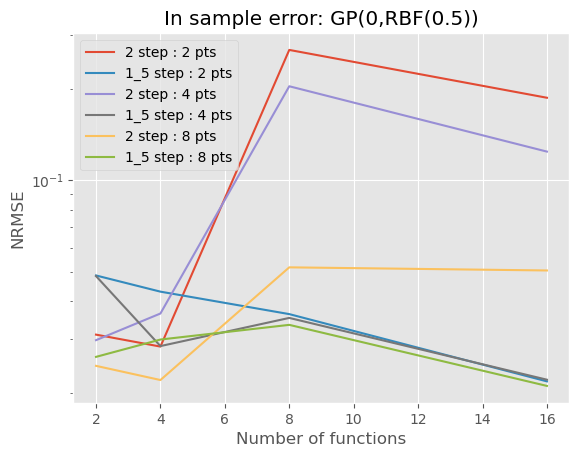

In [12]:
# In sample plot
plt.title('In sample error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_smpl_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # 2 method
    mean_i_smpl_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_i_smpl_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_2 - sd_i_smpl_2, mean_i_smpl_2 + sd_i_smpl_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_smpl_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_1_5 - sd_i_smpl_1_5, mean_i_smpl_1_5 + sd_i_smpl_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

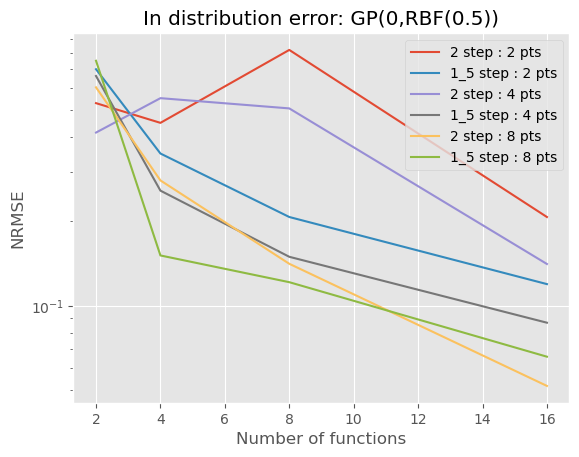

In [13]:
# In distribution plot
plt.title('In distribution error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # 2 method
    mean_i_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_2 - sd_i_dis_2, mean_i_dis_2 + sd_i_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_1_5 - sd_i_dis_1_5, mean_i_dis_1_5 + sd_i_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

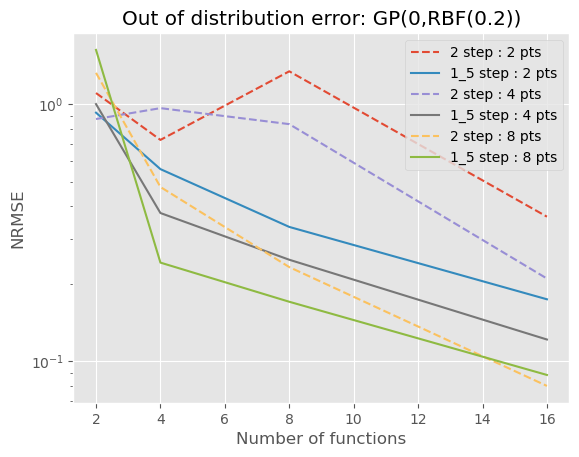

In [15]:
# Out of distribution
plt.title('Out of distribution error: GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_o_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # 2 method
    mean_o_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_o_dis_2, label = f'2 step : {obs_pt} pts',ls = '--')
    plt.fill_between(ms, mean_o_dis_2 - sd_o_dis_2, mean_o_dis_2 + sd_o_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_o_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_1_5 - sd_o_dis_1_5, mean_o_dis_1_5 + sd_o_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()